### Data Preparation and Text Encoding

In [1]:
import numpy as np
import pandas as pd

from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from deepctr.feature_column import SparseFeat, DenseFeat, get_feature_names

from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

from sentence_transformers import SentenceTransformer

from deepctr.models import DeepFM

/home/niranjan/miniconda3/envs/deepctr/lib/python3.7/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
preprocessed_inter_df = pd.read_csv("./MealRec/preprocessed_user_recipe.csv")
preprocessed_inter_df.info()
preprocessed_inter_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 151148 entries, 0 to 151147
Data columns (total 7 columns):
 #   Column     Non-Null Count   Dtype
---  ------     --------------   -----
 0   user_id    151148 non-null  int64
 1   recipe_id  151148 non-null  int64
 2   rating     151148 non-null  int64
 3   year       151148 non-null  int64
 4   month      151148 non-null  int64
 5   day        151148 non-null  int64
 6   hour       151148 non-null  int64
dtypes: int64(7)
memory usage: 8.1 MB


,user_id,recipe_id,rating,year,month,day,hour
0,39,61727,4,2001,3,26,7
1,39,7612,5,2004,8,2,16
2,39,12009,4,2001,2,28,10
3,39,88185,5,2009,5,18,14
4,39,24445,5,2015,5,7,15


In [3]:
preprocessed_recipe_df = pd.read_csv("./MealRec/preprocessed_recipe.csv")
preprocessed_recipe_df.info()
preprocessed_recipe_df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7280 entries, 0 to 7279
Data columns (total 9 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   recipe_id           7280 non-null   int64  
 1   recipe_name         7280 non-null   object 
 2   review_nums         7280 non-null   int64  
 3   category            7280 non-null   object 
 4   aver_rate           7280 non-null   float64
 5   ingredients         7280 non-null   object 
 6   cooking_directions  7280 non-null   object 
 7   nutritions          7280 non-null   object 
 8   tags                7278 non-null   object 
dtypes: float64(1), int64(2), object(6)
memory usage: 512.0+ KB


,recipe_id,recipe_name,review_nums,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,6698,Mom's Zucchini Bread,9355,appetizer,4.754207,purpose flour salt baking soda baking powder g...,directions u prep n20 ncook n1 h nready n1 h 4...,u niacin u hascompletedata true u name u niaci...,north american breads easy beginner cook inexp...
1,6709,Zucchini Walnut Bread,58,appetizer,4.478873,chopped walnuts eggs white sugar vegetable oil...,directions u whisk together flour baking soda ...,u niacin u hascompletedata true u name u niaci...,weeknight breads fruit vegetables kid friendly...
2,6725,Honey Wheat Bread I,2054,appetizer,4.766846,rapid rise yeast white sugar warm water 110 de...,directions u prep n25 ncook n35 nready n2 h 30...,u niacin u hascompletedata true u name u niaci...,healthy breads dietary low cholesterol healthy...
3,6730,Chocolate Chip Orange Zucchini Bread,503,dessert,4.674833,eggs white sugar vegetable oil vanilla extract...,directions u sift together flour baking powder...,u niacin u hascompletedata true u name u niaci...,large groups healthy breads kid friendly dieta...
4,6732,Chocolate Chip Pumpkin Bread,866,dessert,4.718112,white sugar pumpkin puree vegetable oil water ...,directions u prep n30 ncook n1 h nready n1 h 3...,u niacin u hascompletedata true u name u niaci...,breads fall winter seasonal quick breads 4 hou...


In [4]:
input_data_df = pd.merge(preprocessed_inter_df, preprocessed_recipe_df, how="left", on="recipe_id")
input_data_df.info()
input_data_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 151148 entries, 0 to 151147
Data columns (total 15 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   user_id             151148 non-null  int64  
 1   recipe_id           151148 non-null  int64  
 2   rating              151148 non-null  int64  
 3   year                151148 non-null  int64  
 4   month               151148 non-null  int64  
 5   day                 151148 non-null  int64  
 6   hour                151148 non-null  int64  
 7   recipe_name         151148 non-null  object 
 8   review_nums         151148 non-null  int64  
 9   category            151148 non-null  object 
 10  aver_rate           151148 non-null  float64
 11  ingredients         151148 non-null  object 
 12  cooking_directions  151148 non-null  object 
 13  nutritions          151148 non-null  object 
 14  tags                151120 non-null  object 
dtypes: float64(1), int64(8), object(6)

,user_id,recipe_id,rating,year,month,day,hour,recipe_name,review_nums,category,aver_rate,ingredients,cooking_directions,nutritions,tags
0,39,61727,4,2001,3,26,7,Ten Minute Enchilada Sauce,2443,main-dish,4.439774,vegetable oil self rising flour new mexico tom...,directions u prep n10 ncook n15 nready n25 nhe...,u niacin u hascompletedata true u name u niaci...,15 minutes less north american sauces condimen...
1,39,7612,5,2004,8,2,16,Chocolate Lovers' Favorite Cake,848,dessert,4.683846,devil food cake mix instant chocolate pudding ...,directions u prep n30 ncook n1 h nready n2 h n...,u niacin u hascompletedata false u name u niac...,large groups desserts oven cakes chocolate die...
2,39,12009,4,2001,2,28,10,Cajun Chicken Pasta,4573,main-dish,4.676716,linguine pasta boneless skinless chicken breas...,directions u prep n15 ncook n15 nready n30 nbr...,u niacin u hascompletedata false u name u niac...,30 minutes less north american main dish pasta...
3,39,88185,5,2009,5,18,14,Sopapilla Cheesecake,235,dessert,4.793919,cream cheese white sugar vanilla extract refri...,directions u prep n15 ncook n30 nready n45 npr...,u niacin u hascompletedata false u name u niac...,60 minutes less north american desserts eggs d...
4,39,24445,5,2015,5,7,15,Chewy Chocolate Chip Oatmeal Cookies,21731,dessert,4.554303,butter packed light brown sugar white sugar eg...,directions u prep n15 ncook n12 nready n55 npr...,u niacin u hascompletedata true u name u niaci...,30 minutes less large groups breakfast lunch s...


### Text Encoding

In [5]:
soup_columns = ["recipe_name", "ingredients", "cooking_directions", "nutritions", "tags"]
input_data_df[soup_columns] = input_data_df[soup_columns].astype(str)

In [6]:
input_data_df["soup"] = input_data_df.apply(lambda row: ' '.join(row[column] for column in soup_columns), axis=1)

In [7]:
input_data_df.drop(soup_columns, axis=1, inplace=True)
input_data_df.head()

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,soup
0,39,61727,4,2001,3,26,7,2443,main-dish,4.439774,Ten Minute Enchilada Sauce vegetable oil self ...
1,39,7612,5,2004,8,2,16,848,dessert,4.683846,Chocolate Lovers' Favorite Cake devil food cak...
2,39,12009,4,2001,2,28,10,4573,main-dish,4.676716,Cajun Chicken Pasta linguine pasta boneless sk...
3,39,88185,5,2009,5,18,14,235,dessert,4.793919,Sopapilla Cheesecake cream cheese white sugar ...
4,39,24445,5,2015,5,7,15,21731,dessert,4.554303,Chewy Chocolate Chip Oatmeal Cookies butter pa...


In [8]:
input_data_df["rating"].value_counts()

5    101162
4     49986
Name: rating, dtype: int64

In [9]:
input_data_df["rating_binary"] = input_data_df["rating"].apply(lambda x: 1 if x == 5 else 0)
input_data_df["rating_binary"].value_counts()

1    101162
0     49986
Name: rating_binary, dtype: int64

In [10]:
input_data_df["category"].value_counts()

main-dish    69629
dessert      46713
appetizer    34806
Name: category, dtype: int64

### Feature Preparation

In [11]:
input_data_df.columns

Index(['user_id', 'recipe_id', 'rating', 'year', 'month', 'day', 'hour',
       'review_nums', 'category', 'aver_rate', 'soup', 'rating_binary'],
      dtype='object')

In [12]:
sparse_features = ['user_id', 'recipe_id', 'year', 'month', 'day', 'hour', 'review_nums', 'category']
dense_features = ['aver_rate']
dense_vector = ["soup_embedding"]
target = ['rating']
binary_target = ['rating_binary']
len(sparse_features), len(dense_features)

(8, 1)

In [13]:
embedding_model = SentenceTransformer("all-MiniLM-L6-v2")
embeddings = embedding_model.encode(input_data_df["soup"])

In [14]:
embeddings = embeddings.astype(np.float32)
embeddings.shape, type(embeddings), embeddings.dtype

((151148, 384), numpy.ndarray, dtype('float32'))

In [29]:
input_data_df["soup_embedding"] = list(embeddings)
input_data_df.head(2)

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,soup,rating_binary,soup_embedding
0,0,4262,4,1,2,25,7,1071,2,0.846390,Ten Minute Enchilada Sauce vegetable oil self ...,0,"[-0.11143646, -0.040947847, -0.057941463, 0.01..."
1,0,101,5,4,7,1,16,708,1,0.913312,Chocolate Lovers' Favorite Cake devil food cak...,1,"[-0.036412884, -0.053847514, 0.0032289294, 0.0..."


In [36]:
np.array(input_data_df["soup_embedding"].tolist()).shape

(151148, 384)

### Features

In [37]:
# processing the sparse features
for feat in sparse_features:
    lbe = LabelEncoder()
    input_data_df[feat] = lbe.fit_transform(input_data_df[feat])
input_data_df.head(2)

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,soup,rating_binary,soup_embedding
0,0,4262,4,1,2,25,7,1071,2,0.846390,Ten Minute Enchilada Sauce vegetable oil self ...,0,"[-0.11143646, -0.040947847, -0.057941463, 0.01..."
1,0,101,5,4,7,1,16,708,1,0.913312,Chocolate Lovers' Favorite Cake devil food cak...,1,"[-0.036412884, -0.053847514, 0.0032289294, 0.0..."


In [38]:
input_data_df[binary_target].value_counts()

rating_binary
1                101162
0                 49986
dtype: int64

In [39]:
mms = MinMaxScaler(feature_range=(0, 1))
input_data_df[dense_features] = mms.fit_transform(input_data_df[dense_features])

In [40]:
fixlen_feature_columns = [SparseFeat(feat, 
                                     vocabulary_size=input_data_df[feat].max() + 1, 
                                     embedding_dim=8)
                            for feat in sparse_features]

fixlen_feature_columns += [DenseFeat(feat, 1) for feat in dense_features]
fixlen_feature_columns += [DenseFeat(feat, 384, np.float32) for feat in dense_vector]

In [41]:
dnn_feature_columns = fixlen_feature_columns
linear_feature_columns = fixlen_feature_columns
feature_names = get_feature_names(linear_feature_columns + dnn_feature_columns)
len(feature_names), feature_names

(10,
 ['user_id',
  'recipe_id',
  'year',
  'month',
  'day',
  'hour',
  'review_nums',
  'category',
  'aver_rate',
  'soup_embedding'])

In [42]:
input_data_df.head(2)

,user_id,recipe_id,rating,year,month,day,hour,review_nums,category,aver_rate,soup,rating_binary,soup_embedding
0,0,4262,4,1,2,25,7,1071,2,0.846390,Ten Minute Enchilada Sauce vegetable oil self ...,0,"[-0.11143646, -0.040947847, -0.057941463, 0.01..."
1,0,101,5,4,7,1,16,708,1,0.913312,Chocolate Lovers' Favorite Cake devil food cak...,1,"[-0.036412884, -0.053847514, 0.0032289294, 0.0..."


In [57]:
train, test = train_test_split(input_data_df, test_size=0.2, random_state=2020)
train_model_input = {name: train[name].values for name in feature_names if name not in dense_vector}
test_model_input = {name: test[name].values for name in feature_names if name not in dense_vector}

In [59]:
np.array(train["soup_embedding"].tolist()).shape, np.array(test["soup_embedding"].tolist()).shape 

((120918, 384), (30230, 384))

In [60]:
train_model_input["soup_embedding"] = np.array(train["soup_embedding"].tolist())
test_model_input["soup_embedding"] = np.array(test["soup_embedding"].tolist())

In [61]:
train_model_input.keys()

dict_keys(['user_id', 'recipe_id', 'year', 'month', 'day', 'hour', 'review_nums', 'category', 'aver_rate', 'soup_embedding'])

In [62]:
train.info(), test.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 120918 entries, 73154 to 41824
Data columns (total 13 columns):
 #   Column          Non-Null Count   Dtype  
---  ------          --------------   -----  
 0   user_id         120918 non-null  int64  
 1   recipe_id       120918 non-null  int64  
 2   rating          120918 non-null  int64  
 3   year            120918 non-null  int64  
 4   month           120918 non-null  int64  
 5   day             120918 non-null  int64  
 6   hour            120918 non-null  int64  
 7   review_nums     120918 non-null  int64  
 8   category        120918 non-null  int64  
 9   aver_rate       120918 non-null  float64
 10  soup            120918 non-null  object 
 11  rating_binary   120918 non-null  int64  
 12  soup_embedding  120918 non-null  object 
dtypes: float64(1), int64(10), object(2)
memory usage: 12.9+ MB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 30230 entries, 50307 to 731
Data columns (total 13 columns):
 #   Column          

(None, None)

In [73]:
model = DeepFM(linear_feature_columns, dnn_feature_columns, task='binary')
model.compile("adam", "binary_crossentropy", metrics=['binary_crossentropy'], )

In [74]:
EPOCHS = 50
BATCH_SIZE = 256

In [75]:
len(train_model_input["recipe_id"]), len(test_model_input["recipe_id"]), type(train_model_input["recipe_id"])

(120918, 30230, numpy.ndarray)

In [76]:
history = model.fit(train_model_input, 
                    train[binary_target].values, 
                    batch_size=BATCH_SIZE, 
                    epochs=EPOCHS, 
                    verbose=2, 
                    validation_split=0.05, )

Epoch 1/50
449/449 - 3s - loss: 0.5852 - binary_crossentropy: 0.5849 - val_loss: 0.5649 - val_binary_crossentropy: 0.5643
Epoch 2/50
449/449 - 1s - loss: 0.5526 - binary_crossentropy: 0.5517 - val_loss: 0.5714 - val_binary_crossentropy: 0.5701
Epoch 3/50
449/449 - 1s - loss: 0.5421 - binary_crossentropy: 0.5405 - val_loss: 0.5680 - val_binary_crossentropy: 0.5660
Epoch 4/50
449/449 - 1s - loss: 0.5342 - binary_crossentropy: 0.5319 - val_loss: 0.5777 - val_binary_crossentropy: 0.5750
Epoch 5/50
449/449 - 1s - loss: 0.5273 - binary_crossentropy: 0.5242 - val_loss: 0.5833 - val_binary_crossentropy: 0.5799
Epoch 6/50
449/449 - 1s - loss: 0.5183 - binary_crossentropy: 0.5146 - val_loss: 0.5928 - val_binary_crossentropy: 0.5888
Epoch 7/50
449/449 - 1s - loss: 0.5100 - binary_crossentropy: 0.5057 - val_loss: 0.6175 - val_binary_crossentropy: 0.6130
Epoch 8/50
449/449 - 1s - loss: 0.5017 - binary_crossentropy: 0.4970 - val_loss: 0.6208 - val_binary_crossentropy: 0.6159
Epoch 9/50
449/449 - 1s 

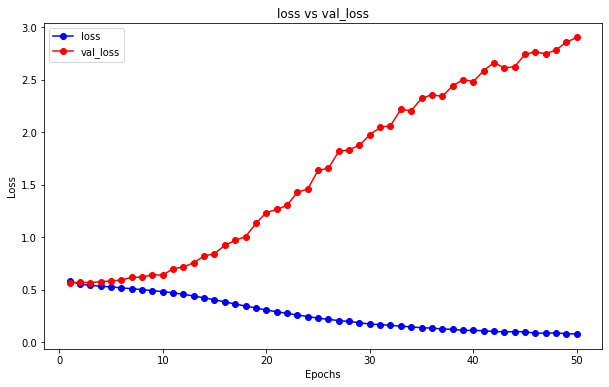

In [77]:
import matplotlib.pyplot as plt
# Extract loss and validation loss values
def plot_history(history, train_metric: str, val_metric: str):
    history_dict = history.history

    loss = history_dict[train_metric]
    val_loss = history_dict[val_metric]
    # Create an array with epoch numbers
    epochs = range(1, len(loss) + 1)

    # Plotting the training and validation loss
    plt.figure(figsize=(10, 6))
    plt.plot(epochs, loss, 'bo-', label=train_metric)
    plt.plot(epochs, val_loss, 'ro-', label=val_metric)
    plt.title(f'{train_metric} vs {val_metric}')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()
    plt.show()

plot_history(history, "loss", "val_loss")

In [78]:
pred_ans = model.predict(test_model_input, batch_size=256)
print("test MSE", round(mean_squared_error(test[binary_target].values, pred_ans), 4))

test MSE 0.3353


### Manual Evaluation

In [79]:
ground_truth = test[binary_target].values
prediction = pred_ans
type(ground_truth), type(prediction)

(numpy.ndarray, numpy.ndarray)

In [80]:
import numpy as np
indices = np.random.choice(30230, size=10, replace=False)
sample_array1 = ground_truth[indices]
sample_array2 = prediction[indices]

In [83]:
df = pd.DataFrame({'truth': sample_array1.flatten(), 'pred': sample_array2.flatten()})
df['diff'] = np.abs(df['truth'] - df['pred'])
df.round(4)


,truth,pred,diff
0,1,0.0000,1.0000
1,1,0.0790,0.9210
2,0,0.0000,0.0000
3,1,1.0000,0.0000
4,0,0.9984,0.9984
5,0,1.0000,1.0000
6,1,1.0000,0.0000
7,0,1.0000,1.0000
8,1,0.9658,0.0342
9,1,0.3282,0.6718


### Model Inference

In [84]:
feature_names

['user_id',
 'recipe_id',
 'year',
 'month',
 'day',
 'hour',
 'review_nums',
 'category',
 'aver_rate',
 'soup_embedding']

In [85]:
test_model_input

{'user_id': array([477, 461, 404, ..., 547, 189,   6]),
 'recipe_id': array([3931, 1099,  717, ..., 2297, 4364, 2003]),
 'year': array([ 5, 13,  9, ..., 17,  8,  6]),
 'month': array([ 9, 10,  2, ...,  0,  2,  1]),
 'day': array([ 3, 16, 17, ...,  8, 13, 10]),
 'hour': array([14, 13,  1, ...,  0,  7,  9]),
 'review_nums': array([ 246, 1106, 1211, ...,  938, 1046, 1080]),
 'category': array([2, 1, 1, ..., 2, 2, 0]),
 'aver_rate': array([0.78837414, 0.91249519, 0.87098815, ..., 0.83507911, 0.83883439,
        0.94490743]),
 'soup_embedding': array([[-0.00548283, -0.05072612, -0.03537296, ..., -0.08018075,
         -0.03655843, -0.00328475],
        [-0.00262577, -0.0482248 ,  0.00495016, ..., -0.05757214,
         -0.00810685, -0.05366195],
        [-0.05077625, -0.09264302, -0.00516207, ..., -0.08097457,
         -0.04199636, -0.02631684],
        ...,
        [-0.07636411, -0.07031645, -0.00827871, ..., -0.04816492,
         -0.04116781,  0.02848059],
        [-0.03975313, -0.05485952,

In [89]:
sample_data = input_data_df.iloc[0]
sample_data

user_id                                                           0
recipe_id                                                      4262
rating                                                            4
year                                                              1
month                                                             2
day                                                              25
hour                                                              7
review_nums                                                    1071
category                                                          2
aver_rate                                                   0.84639
soup              Ten Minute Enchilada Sauce vegetable oil self ...
rating_binary                                                     0
soup_embedding    [-0.11143646, -0.040947847, -0.057941463, 0.01...
Name: 0, dtype: object

In [98]:
inference_input_data = {feat:np.array([sample_data[feat]]) for feat in feature_names}
inference_input_data["soup_embedding"].shape

(1, 384)

In [99]:
inference_input_data

{'user_id': array([0]),
 'recipe_id': array([4262]),
 'year': array([1]),
 'month': array([2]),
 'day': array([25]),
 'hour': array([7]),
 'review_nums': array([1071]),
 'category': array([2]),
 'aver_rate': array([0.84638953]),
 'soup_embedding': array([[-1.11436456e-01, -4.09478471e-02, -5.79414628e-02,
          1.59534682e-02, -1.89360492e-02,  3.74121442e-02,
          1.25898048e-02,  1.39774731e-03, -4.88943793e-02,
         -1.01665147e-01, -1.00389468e-02, -1.04857825e-01,
          3.70231946e-03, -9.39152837e-02, -6.58409018e-03,
         -6.45534769e-02,  1.61246091e-01,  2.58033909e-02,
         -6.86128065e-02, -1.10628575e-01,  6.69355541e-02,
          4.57302704e-02,  2.88913548e-02, -4.26467555e-03,
          1.62896849e-02, -4.96225944e-03, -8.08038004e-03,
         -2.24283375e-02, -5.81778511e-02, -4.78904359e-02,
          4.20787670e-02,  7.54145533e-02, -2.12253220e-02,
          5.32825198e-03, -3.66442204e-02,  1.58074927e-02,
         -1.62647311e-02, -1.5013

In [100]:
model.predict(inference_input_data)

array([[0.0077823]], dtype=float32)